In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# HW6

## Q1

In [2]:
np.random.seed(365)
n = 100
mu_0, sigma_0, nu_0 = 3, 2, 15
x = stats.t(loc=mu_0, scale=sigma_0, df=nu_0).rvs(size=n)
C, G = 2, 1000
mu, sigma, nu = np.zeros([C, G]), np.zeros([C, G]), np.zeros([C, G])
mu[:, 0], sigma[:, 0], nu[:, 0] = 3, 2, 15

for c in range(C):
    for g in range(1, G):
        mu_tar = lambda mu_: np.prod(stats.t(loc=mu_, scale=sigma[c, g-1], df=nu[c, g-1]).pdf(x)) *\
                             stats.norm(loc=2, scale=1).pdf(mu[c, g-1])
        mu_til = stats.norm(loc=3, scale=0.3).rvs()
        mu_mh = mu_tar(mu_til) / mu_tar(mu[c, g-1]) 
        mu_log_ap = np.log(min(1, mu_mh))
        if np.log(stats.uniform().rvs()) < mu_log_ap:
            mu[c, g] = mu_til
        else:
            mu[c, g] = mu[c, g-1]

        sigma_tar = lambda sigma_: np.prod(stats.t(loc=mu[c, g], scale=sigma_, df=nu[c, g-1]).pdf(x)) *\
                                   stats.halfnorm(scale=3).pdf(sigma[c, g-1])
        sigma_prop = stats.halfnorm(loc=2, scale=0.3)
        sigma_til = sigma_prop.rvs()
        sigma_mh = sigma_tar(sigma_til) * sigma_prop.pdf(sigma[c, g-1]) /\
                   (sigma_tar(sigma[c, g-1]) * sigma_prop.pdf(sigma_til))
        sigma_log_ap = np.log(min(1, sigma_mh))
        if np.log(stats.uniform().rvs()) < sigma_log_ap:
            sigma[c, g] = sigma_til
        else:
            sigma[c, g] = sigma[c, g-1]

        nu_tar = lambda nu_: np.prod(stats.t(loc=mu[c, g], scale=sigma[c, g], df=nu_).pdf(x)) *\
                             stats.randint(low=1, high=101).pmf(nu[c, g-1])
        nu_til = stats.randint(low=1, high=31).rvs()
        nu_mh = nu_tar(nu_til) / nu_tar(nu[c, g-1])
        nu_log_ap = np.log(min(1, nu_mh))
        if np.log(stats.uniform().rvs()) < nu_log_ap:
            nu[c, g] = nu_til
        else:
            nu[c, g] = nu[c, g-1]

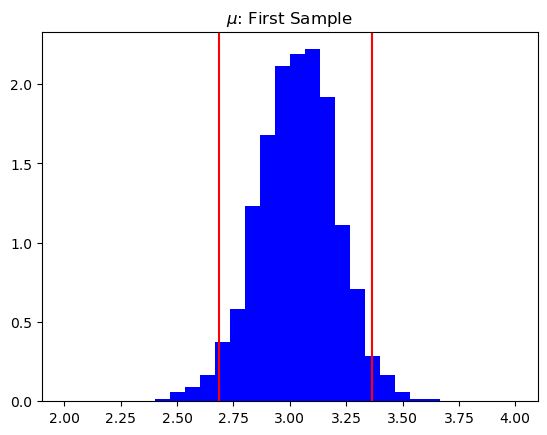

95% Credible Interval:  [2.68378274 3.36252731]


In [3]:
plt.hist(mu[0, :], bins=30, range=(2, 4), density=True, color="blue")
plt.axvline(np.quantile(mu[0, :], 0.025), color="red")
plt.axvline(np.quantile(mu[0, :], 0.975), color="red")
plt.title(r"$\mu$: First Sample")
plt.show()
print("95% Credible Interval: ", np.quantile(mu[0, :], [0.025, 0.975]))

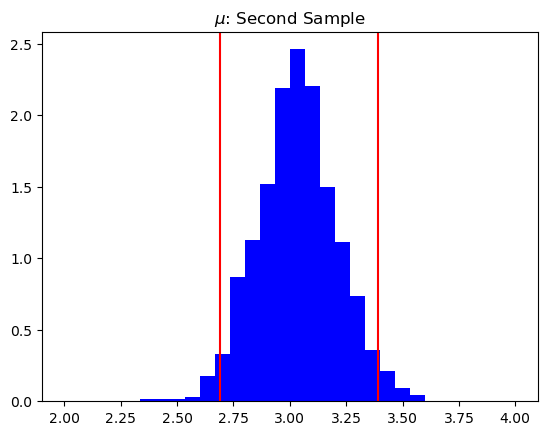

95% Credible Interval:  [2.69213626 3.39223182]


In [4]:
plt.hist(mu[1, :], bins=30, range=(2, 4), density=True, color="blue")
plt.axvline(np.quantile(mu[1, :], 0.025), color="red")
plt.axvline(np.quantile(mu[1, :], 0.975), color="red")
plt.title(r"$\mu$: Second Sample")
plt.show()
print("95% Credible Interval: ", np.quantile(mu[1, :], [0.025, 0.975]))

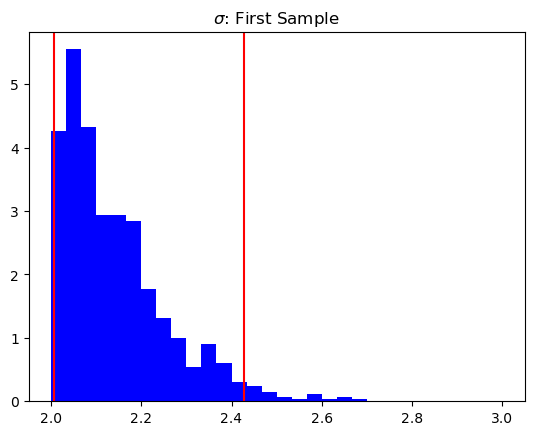

95% Credible Interval:  [2.00541169 2.42788445]


In [5]:
plt.hist(sigma[0, :], bins=30, range=(2, 3), density=True, color="blue")
plt.axvline(np.quantile(sigma[0, :], 0.025), color="red")
plt.axvline(np.quantile(sigma[0, :], 0.975), color="red")
plt.title(r"$\sigma$: First Sample")
plt.show()
print("95% Credible Interval: ", np.quantile(sigma[0, :], [0.025, 0.975]))

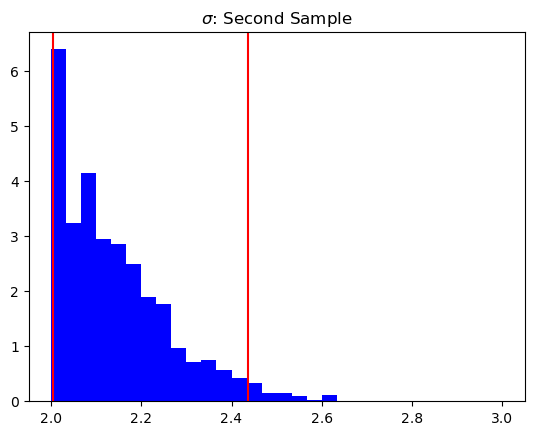

95% Credible Interval:  [2.0037089  2.43745589]


In [6]:
plt.hist(sigma[1, :], bins=30, range=(2, 3), density=True, color="blue")
plt.axvline(np.quantile(sigma[1, :], 0.025), color="red")
plt.axvline(np.quantile(sigma[1, :], 0.975), color="red")
plt.title(r"$\sigma$: Second Sample")
plt.show()
print("95% Credible Interval: ", np.quantile(sigma[1, :], [0.025, 0.975]))

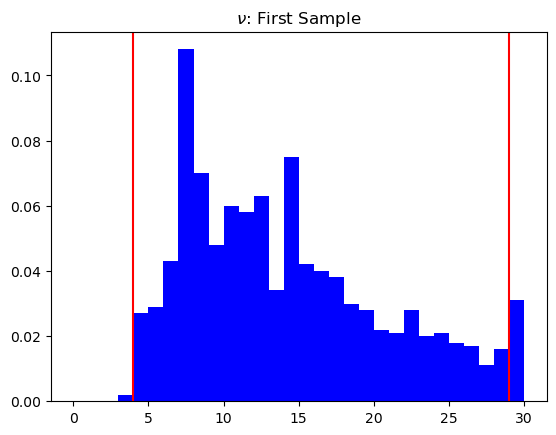

95% Credible Interval:  [ 4. 29.]


In [7]:
plt.hist(nu[0, :], bins=30, range=(0, 30), density=True, color="blue")
plt.axvline(np.quantile(nu[0, :], 0.025), color="red")
plt.axvline(np.quantile(nu[0, :], 0.975), color="red")
plt.title(r"$\nu$: First Sample")
plt.show()
print("95% Credible Interval: ", np.quantile(nu[0, :], [0.025, 0.975]))

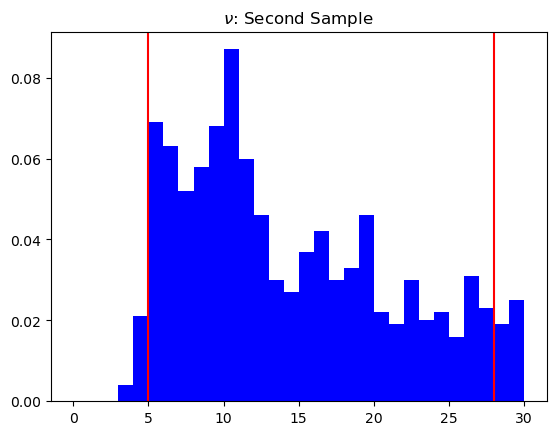

95% Credible Interval:  [ 4.975 28.025]


In [8]:
plt.hist(nu[1, :], bins=30, range=(0, 30), density=True, color="blue")
plt.axvline(np.quantile(nu[1, :], 0.025), color="red")
plt.axvline(np.quantile(nu[1, :], 0.975), color="red")
plt.title(r"$\nu$: Second Sample")
plt.show()
print("95% Credible Interval: ", np.quantile(nu[1, :], [0.025, 0.975]))

## Q2

In [9]:
d = 10000

np.random.seed(365)
n1 = 10
x1 = stats.t(loc=mu_0, scale=sigma_0, df=nu_0).rvs(size=n1)

with pm.Model() as model1:
    mu = pm.Normal("mu", mu=2, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=3)
    nu = pm.DiscreteUniform("nu", lower=1, upper=100)
    x_obs = pm.StudentT("x_obs", mu=mu, sigma=sigma, nu=nu, observed=x1)
    idata1 = pm.sample(draws=d, chains=2, tune=100, random_seed=365)

az.summary(idata1, round_to=3)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.657,0.685,1.336,3.954,0.009,0.009,6048.464,5772.623,1.003
nu,38.291,34.682,1.000,95.000,21.197,6.990,3.413,32.874,1.636
sigma,2.803,0.936,0.941,4.513,0.223,0.016,16.888,154.906,1.087


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

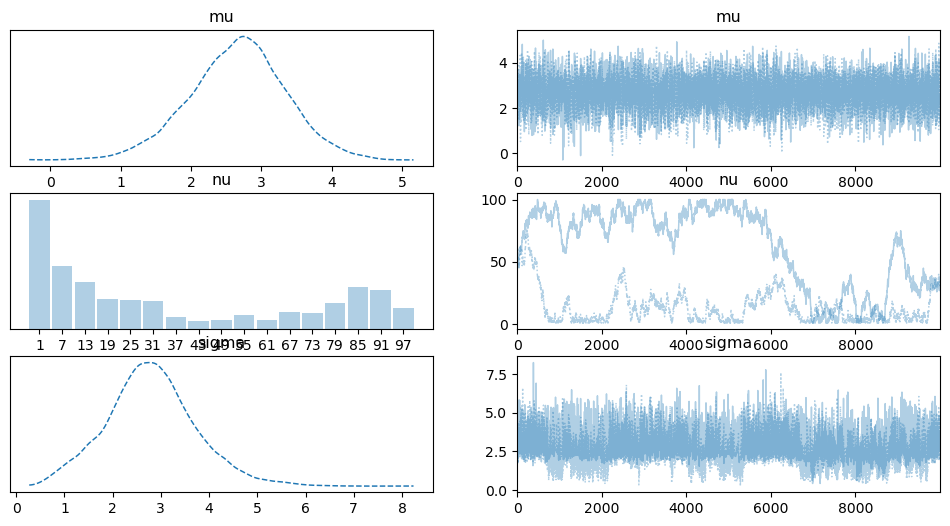

In [10]:
az.plot_trace(idata1, combined=True)

In [11]:
np.random.seed(365)
n2 = 100
x2 = stats.t(loc=mu_0, scale=sigma_0, df=nu_0).rvs(size=n2)

with pm.Model() as model2:
    mu = pm.Normal("mu", mu=2, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=3)
    nu = pm.DiscreteUniform("nu", lower=1, upper=100)
    x_obs = pm.StudentT("x_obs", mu=mu, sigma=sigma, nu=nu, observed=x2)
    idata2 = pm.sample(draws=d, chains=2, tune=100, random_seed=365)

az.summary(idata2, round_to=3)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3.014,0.205,2.626,3.402,0.003,0.002,5931.338,6819.546,1.000
nu,12.380,12.673,2.000,40.000,4.308,5.140,16.090,12.811,1.107
sigma,1.903,0.237,1.481,2.357,0.042,0.014,33.759,82.792,1.042


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

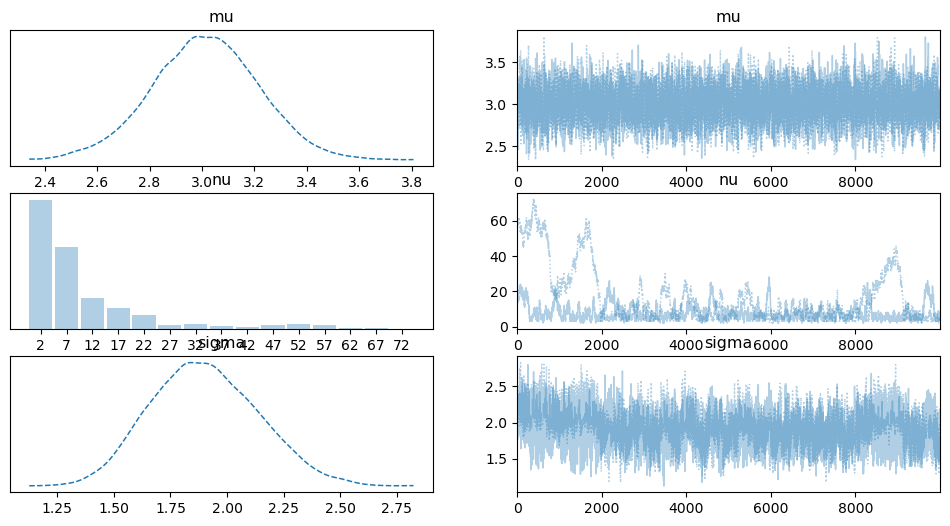

In [12]:
az.plot_trace(idata2, combined=True)

In [13]:
np.random.seed(365)
n3 = 10000
x3 = stats.t(loc=mu_0, scale=sigma_0, df=nu_0).rvs(size=n3)

with pm.Model() as model3:
    mu = pm.Normal("mu", mu=2, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=3)
    nu = pm.DiscreteUniform("nu", lower=1, upper=100)
    x_obs = pm.StudentT("x_obs", mu=mu, sigma=sigma, nu=nu, observed=x3)
    idata3 = pm.sample(draws=d, chains=2, tune=100, random_seed=365)

az.summary(idata3, round_to=3)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3.020,0.021,2.978,3.058,0.000,0.000,5513.668,6847.893,1.000
nu,13.910,2.009,11.000,17.000,0.093,0.310,760.802,668.265,1.002
sigma,1.984,0.023,1.941,2.025,0.001,0.001,1199.523,1412.494,1.001


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

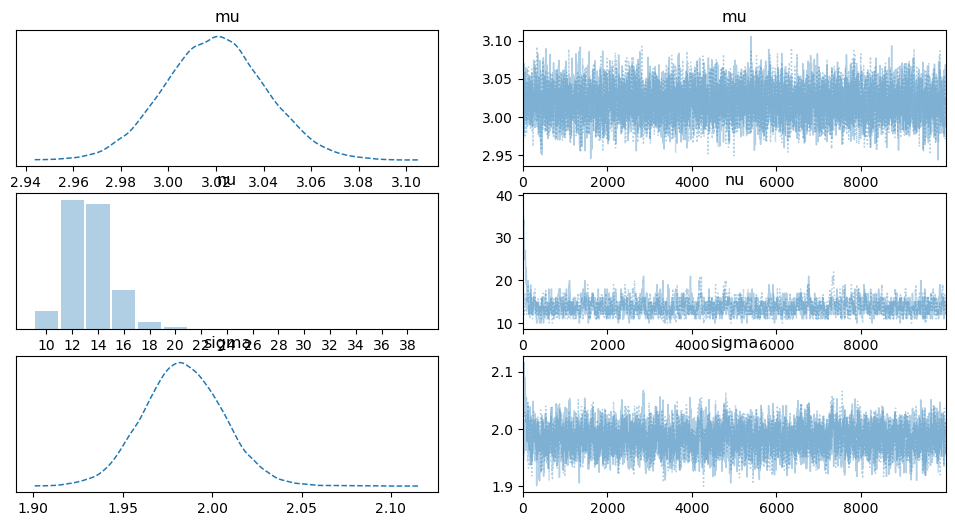

In [14]:
az.plot_trace(idata3, combined=True)

With the increase of `n`, the variance of $\nu$ decreases, and the two chains of $\nu$ overlap more. A larger sample size increases the power of the likelihood, leading to a more accurate estimation of $\nu$.

## Q3

$\Large
\begin{align*}
p(y_i)&=\int p(y_i|\tau_i)p(\tau_i)d\tau_i\\
&=\int\sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_iy_i^2}\frac{\left(\frac{\nu}{2}\right)^\frac{\nu}{2}}{\Gamma\left(\frac{\nu}{2}\right)}\tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i}d\tau_i\\
&=\frac{\left(\frac{\nu}{2}\right)^\frac{\nu}{2}}{\sqrt{2\pi}\Gamma\left(\frac{\nu}{2}\right)}\int\tau_i^{\frac{\nu+1}{2}-1}e^{-\frac{y_i^2+\nu}{2}\tau_i}d\tau_i\\
&=\frac{\left(\frac{\nu}{2}\right)^\frac{\nu}{2}}{\sqrt{2\pi}\Gamma\left(\frac{\nu}{2}\right)}\int\tau_i^{a-1}e^{-b\tau_i}d\tau_i\\
&=\frac{\left(\frac{\nu}{2}\right)^\frac{\nu}{2}}{\sqrt{2\pi}\Gamma\left(\frac{\nu}{2}\right)}\frac{\Gamma(a)}{b^a}\\
&=\frac{\left(\frac{\nu}{2}\right)^\frac{\nu}{2}}{\sqrt{2\pi}\Gamma\left(\frac{\nu}{2}\right)}\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\frac{y_i^2+\nu}{2}^{\frac{\nu+1}{2}}}\\
&=\frac{\nu^\frac{\nu}{2}\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\pi}\Gamma\left(\frac{\nu}{2}\right)}\frac{1}{(y_i^2+\nu)^{\frac{\nu+1}{2}}}\\
&=\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu\pi}\Gamma\left(\frac{\nu}{2}\right)}\left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}\\
&\sim\text{t}_\nu
\end{align*}$

When $\tau_i$ is known, $y_i$ follows a normal distribution. However, when $\tau_i$ follows a gamma distribution (unknown), $y_i$ follows a t distribution, which has heavier tails. This means the uncertainty in $\tau_i$ brings more variation to $y_i$.